## Dataset assemblies

This notebook is used to read raw data and assemble AnnData objects for model training. 

There are two main datasets: the supervised one which has cells labeled by expansion phase, and the semi-supervised one which is partially labeled. Both are assembled multiple ways to change how many genes they consider, and how do they take the subset of genes considered.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import h5py
import scanpy as sc
import scipy.sparse as sp
import numpy as np

In [3]:
os.chdir('/pool01/')

data_dir = 'data/public/handsaker2025/'

snrna_counts_dir = f'{data_dir}Analysis_bag_2_Broad_Huntingtons_Caudate_2024_10xv3.1_snRNA-seq_Counts_Open/'
snrna_metadata_dir = f'{data_dir}Analysis_bag_4_Broad_Huntingtons_Caudate_2024_10xv3.1_snRNA-seq_Metadata_Open/'
cag_dir = f'{data_dir}Analysis_bag_6_Broad_Huntingtons_Caudate_2024_PacBio_Metadata_Open/'

proj_dir = '/pool01/projects/abante_lab/cag_propagation/'

In [4]:
pacbio = pd.read_csv(f'{cag_dir}pacbio_deepdives_cells_unfiltered.txt', sep='\t')
pacbio.head(5)

,CELL_BARCODE,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE
0,S05202_Caudate_DeepDive_rxn1_AATGGCTTCGTTGTTT,AAACAACGAAGCCATT.GTATAATCAGGC,918,769,43,EXON2,3074853.0,3075088.0,S05202,CD,astrocyte
1,S05202_Caudate_DeepDive_rxn1_GTCTACCCAGGTGTTT,AAACACCTGGGTAGAC.ACATATTTGAAG,1130,690,15,EXON2,3074853.0,3075088.0,S05202,CD,SPN
2,S05202_Caudate_DeepDive_rxn1_GACTATGGTCGAGTTT,AAACTCGACCATAGTC.CCTGACATTGGT,221,517,42,POLYA,3074853.0,3075088.0,S05202,CD,polydendrocyte
3,S05202_Caudate_DeepDive_rxn1_TGTGCGGAGGGTCTTT,AAAGACCCTCCGCACA.AACCAAAAAATA,177,1106,42,EXON2,3074853.0,3075088.0,S05202,CD,interneuron
4,S05202_Caudate_DeepDive_rxn1_AGATGAATCAGTCTTT,AAAGACTGATTCATCT.ATGGTTAATCCT,142,438,15,POLYA,3074853.0,3075088.0,S05202,CD,microglia


In [5]:
pacbio['DONOR'].unique()

array(['S05202', 'S12365', 'S04577', 'S07681', 'S06758', 'S04002',
       'S09619', 'S02205', 'S05368'], dtype=object)

In [6]:
pacbio[pacbio['DONOR']=='S04002']

,CELL_BARCODE,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE
23402,S04002_rxn1_CTCTCGATCAGGTGTT,AACACCTGATCGAGAG.CTTAAAAACTTT,364,442,17,POLYA,3074853.0,3075087.0,S04002,CD,interneuron
23403,S04002_rxn1_CACTAAGTCATTCGTT,AACGAATGACTTAGTG.CAGCTGCAATAA,263,694,17,EXON2,3074853.0,3103870.0,S04002,CD,microglia
23404,S04002_rxn1_TCCTTCTCACCTCGTT,AACGAGGTGAGAAGGA.AGAAAGACGGTC,242,444,17,POLYA,3074853.0,3075086.0,S04002,CD,SPN
23405,S04002_rxn1_TCCTGCAGTGATCGTT,AACGATCACTGCAGGA.ACCTTAAAAAAA,271,517,42,POLYA,3074853.0,3075088.0,S04002,CD,astrocyte
23406,S04002_rxn1_AGGTTACAGCGCCGTT,AACGGCGCTGTAACCT.TCGTGTCTGGTG,245,442,17,POLYA,3074853.0,3075087.0,S04002,CD,SPN
...,...,...,...,...,...,...,...,...,...,...,...
27328,S04002_rxn8_CAAGCTACAGCGACAA,TTGTCGCTGTAGCTTG.TTGTGCAACAAC,115,712,17,EXON2,3074853.0,3086965.0,S04002,CD,astrocyte
27329,S04002_rxn8_AGTAACCGTATCGAAA,TTTCGATACGGTTACT.AAGACTTGCGTA,894,1998,42,EXON2,3074853.0,3121268.0,S04002,CD,polydendrocyte
27330,S04002_rxn8_GCCGTGACAATCGAAA,TTTCGATTGTCACGGC.CGTTAGGTAGAC,246,1788,42,EXON2,3074853.0,3121716.0,S04002,CD,interneuron
27331,S04002_rxn8_GCCAACGGTGCCGAAA,TTTCGGCACCGTTGGC.AACACCAATCCG,585,1715,17,EXON2,3074853.0,3121716.0,S04002,CD,SPN


In [7]:
village_metadata = pd.read_csv(f'{snrna_metadata_dir}10x_village_cell_metadata.txt', sep='\t')
village_metadata.head(5)

,PREFIX,CBC,CELL_BARCODE,predClass,max.prob,DONOR,NUM_GENIC_READS,NUM_TRANSCRIPTS,NUM_GENES
0,Village1_rxn1,TACGTCCCACTAACCA,Village1_rxn1_TACGTCCCACTAACCA,SPN,1.0,S17094,196791,53217,7831
1,Village1_rxn1,CCCTCAATCACCCTCA,Village1_rxn1_CCCTCAATCACCCTCA,SPN,1.0,S02574,144034,38141,7514
2,Village1_rxn1,AAGATAGTCTATCGTT,Village1_rxn1_AAGATAGTCTATCGTT,SPN,1.0,S01733,138626,38099,7036
3,Village1_rxn1,GAGACTTAGATCCAAA,Village1_rxn1_GAGACTTAGATCCAAA,SPN,1.0,S01780,122879,36720,6466
4,Village1_rxn1,ACCCAAAGTCTTTCAT,Village1_rxn1_ACCCAAAGTCTTTCAT,SPN,1.0,S02574,127869,36804,7262


In [8]:
# Rename predClass to CELLTYPE (the minimum prob of assignment to a cell type is 0.8)
village_metadata.rename(columns={'predClass': 'CELLTYPE'}, inplace=True)

In [9]:
donor_metadata = pd.read_csv(f'{snrna_metadata_dir}donor_metadata.txt', sep='\t')
donor_metadata.head(5)

,Donor,SID,Age,Sex,Status,CAG,PMI,VS_Grade,Onset/Motor,Onset/Cog,CAP,CAP-100
0,1,S05202,67,Male,Case,15/42,23.36,HD-3,40.0,42.0,559,123.9
1,2,S12365,81,Female,Case,17/40,17.33,HD-0,75.0,NaN,514,124.8
2,3,S07681,69,Male,Case,16/42,18.16,HD-1,NaN,NaN,575,127.6
3,4,S06758,37,Female,Case,18/43,16.40,HD-1,NaN,NaN,346,74.1
4,5,S04002,58,Male,Case,17/42,13.45,HD-2,30.0,NaN,484,107.2


In [16]:
donor_metadata[donor_metadata['SID']=='S05368']

,Donor,SID,Age,Sex,Status,CAG,PMI,VS_Grade,Onset/Motor,Onset/Cog,CAP,CAP-100
7,8,S05368,44,Female,Case,16/39,4.3,NaN,NaN,NaN,235,61.0


In [10]:
def c_read_h5_pacbio(h5_file, meta_df, donor_meta):
    # Load the data from the HDF5 file
    with h5py.File(h5_file, "r") as f:
        
        # Assuming structure like: matrix/data, matrix/indices, etc.
        data = f['matrix/data'][:]
        indices = f['matrix/indices'][:]
        indptr = f['matrix/indptr'][:]
        shape = f['matrix/shape'][:]

        # Create a sparse matrix from the data
        # Note: The original matrix is in CSC format, we convert it to CSR format
        matrix = sp.csc_matrix((data, indices, indptr), shape=shape).transpose().tocsr()

        # Extract barcodes and gene names
        barcodes = f['matrix/barcodes'][:].astype(str)
        gene_names = f['matrix/features/name'][:].astype(str)
        feature_type = f['matrix/features/feature_type'][:].astype(str) # All are gene expression

    # Construct AnnData object manually
    adata = ad.AnnData(X=matrix)
    adata.obs['BARCODE'] = barcodes
    adata.var_names = gene_names
    adata.obs['DONOR'] = h5_file.split('/')[-1].split('_')[0]

    # Create mapping from donor ID to Age
    donor_age_map = donor_meta.set_index('SID')['Age'].to_dict()

    # Map age to each donor in adata.obs['DONOR']
    adata.obs['AGE'] = adata.obs['DONOR'].map(donor_age_map)
    
    # Cell barcode to match metadata barcode name
    prefix = h5_file.split('/')[-1].split('.')[0] 
    prefix_parts = prefix.split('_')
    prefix = '_'.join([prefix_parts[0]] + prefix_parts[2:])
    adata.obs['CELL_BARCODE'] = prefix + '_' + adata.obs['BARCODE']

    # Batch

    # Extract batch from CELL_BARCODE: assumes 'rxnX' is in barcode string
    if "CELL_BARCODE" in adata.obs:
        barcodes = adata.obs["CELL_BARCODE"]
        batches = barcodes.str.extract(r'rxn(\d+)')[0].astype(str)
        adata.obs["BATCH"] = adata.obs["DONOR"] + "rxn" + batches
    
    # Filter metadata for this sample
    sample_pacbio = meta_df[meta_df['CELL_BARCODE'].isin(adata.obs['CELL_BARCODE'])]

    # join metadata to AnnData object observation
    adata.obs = adata.obs.set_index('CELL_BARCODE', drop=False)
    adata.obs = adata.obs.join(sample_pacbio.set_index('CELL_BARCODE'), how='left', lsuffix='_snrnadata')

    adata = adata[adata.obs['CAGLENGTH'] == adata.obs['CAGLENGTH']]
    
    # Discretize CAGLENGTH into phases
    def assign_cag_phase(val):
        if pd.isnull(val):
            return np.nan
        if val < 80:
            return 'A'
        elif val < 150:
            return 'B'
        elif val < 500:
            return 'C'
        else:
            return 'D'

    adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)

    return adata

In [10]:
donors = ['S05202', 'S12365', 'S04577', 'S07681', 'S06758', 'S09619', 'S02205', 'S05368']

# First donor anndata
all_adata = None

for donor in donors:
    for file in os.listdir(snrna_counts_dir):
        if file.startswith(donor) & file.endswith('exonic+intronic.h5'):
            if not all_adata:
                all_adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            else:
                adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
                all_adata = ad.concat([all_adata, adata], axis=0)

/tmp/ipykernel_95735/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_95735/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_95735/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_95735/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_95735/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.

In [11]:
all_adata.obs = all_adata.obs.drop(columns=['DONOR_snrnadata'])
all_adata.obs

,BARCODE,AGE,CELL_BARCODE,BATCH,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE,CAGPHASE
CELL_BARCODE,,,,,,,,,,,,,,,
S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,ATTTCTGCAGCGACCT,67,S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,S05202rxn1,AGGTCGCTGCAGAAAT.TGGATTAATGTA,460.0,593.0,67.0,POLYA,3074853.0,3075086.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,GATGACTAGGCTAAAT,67,S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,S05202rxn1,ATTTAGCCTAGTCATC.CCACACAATTTG,426.0,1196.0,15.0,EXON2,3074853.0,3116219.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,CATCCGTAGTCTAGAA,67,S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,S05202rxn1,TTCTAGACTACGGATG.GACAGGCCAGGA,645.0,1387.0,63.0,INTRON1,3074853.0,3075899.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,ACCAACAGTGTACATC,67,S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,S05202rxn1,GATGTACACTGTTGGT.ATGCAGGAAATC,1351.0,2215.0,156.0,INTRON1,3074877.0,3076449.0,S05202,CD,SPN,C
S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,TTCTCTCGTTGCTCCT,67,S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,S05202rxn1,AGGAGCAACGAGAGAA.TGAGTCCAATTG,1017.0,691.0,15.0,EXON2,3074853.0,3075088.0,S05202,CD,SPN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S05368_Caudate_DeepDive_rxn3_CAATGACAGGTCATTC,CAATGACAGGTCATTC,44,S05368_Caudate_DeepDive_rxn3_CAATGACAGGTCATTC,S05368rxn3,GAATGACCTGTCATTG.GACTTGCAAGGA,511.0,507.0,39.0,POLYA,3074853.0,3075088.0,S05368,CD,astrocyte,A
S05368_Caudate_DeepDive_rxn3_GGTTCTCTCCCAGGAC,GGTTCTCTCCCAGGAC,44,S05368_Caudate_DeepDive_rxn3_GGTTCTCTCCCAGGAC,S05368rxn3,GTCCTGGGAGAGAACC.AGTGTATCTCGA,422.0,450.0,16.0,POLYA,3074853.0,3075088.0,S05368,CD,astrocyte,A
S05368_Caudate_DeepDive_rxn3_CTCGAGGCAGAACATA,CTCGAGGCAGAACATA,44,S05368_Caudate_DeepDive_rxn3_CTCGAGGCAGAACATA,S05368rxn3,TATGTTCTGCCTCGAG.AATAGAAAAGGA,152.0,448.0,16.0,POLYA,3074853.0,3075087.0,S05368,CD,astrocyte,A


In [12]:
# Drop cells with CAGPHASE == D
all_adata = all_adata[all_adata.obs['CAGPHASE'] != 'D']

In [35]:
all_adata.obs['AGE'] = pd.to_numeric(all_adata.obs['AGE'], errors='coerce')

/tmp/ipykernel_2667235/2907943796.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['AGE'] = pd.to_numeric(all_adata.obs['AGE'], errors='coerce')


In [36]:
# Save all anndata
all_adata.write_h5ad(proj_dir + 'handsaker_pacbio_deepdive.h5')

In [28]:
# Filter data to 2k most variable genes

def norm_log(all_adata):
    # Create counts layer to preserve raw counts intact
    all_adata.layers['raw'] = all_adata.X.copy()
    all_adata.layers['counts'] = all_adata.X.copy()

    # Normalize and log transform
    sc.pp.normalize_total(all_adata, target_sum=1e4, layer='counts')
    sc.pp.log1p(all_adata, layer='counts')

    return all_adata

In [ ]:
all_adata = norm_log(all_adata)

We have 2 different ways of selecting the most variable genes:

- v1: jus the 2k most variable, without any type of balancing strategy
- v2: the union of the 2k most variable in general, and 1k amongst SPNs (total: 2459 genes)

In [1]:
n_genes = 8000

In [35]:
# Most variable and subset
def subset_hvgenes_v1(all_adata, n_genes, proj_dir):
    sc.pp.highly_variable_genes(all_adata, n_top_genes=n_genes, layer='counts', subset=True)
    all_adata.obs['AGE'] = pd.to_numeric(all_adata.obs['AGE'], errors='coerce')
    # all_adata.write_h5ad(proj_dir + f'deep_dive_adata_v1_{n_genes}.h5',compression='gzip')

    return all_adata

In [ ]:
all_adata = subset_hvgenes_v1(all_adata, n_genes, proj_dir)

In [ ]:
def subset_hvgenes_v2(all_adata, n_genes, proj_dir):
    # Global HVGs (all cells)
    sc.pp.highly_variable_genes(
        all_adata, 
        n_top_genes=n_genes, 
        layer="counts", 
        subset=False,  # keep all genes, just annotate
        inplace=True
    )
    hvg_global = all_adata.var.loc[all_adata.var['highly_variable']].index

    # HVGs within SPN cells only
    adata_spn = all_adata[all_adata.obs['CELLTYPE'] == 'SPN']

    sc.pp.highly_variable_genes(
        adata_spn, 
        n_top_genes=1000, 
        layer="counts", 
        subset=False, 
        inplace=True
    )
    hvg_spn = adata_spn.var.loc[adata_spn.var['highly_variable']].index

    # Union of both sets
    hvg_union = np.union1d(hvg_global, hvg_spn)

    # Subset to these genes 
    all_adata = all_adata[:, hvg_union].copy()

    del all_adata.layers['counts']

    return all_adata

all_adata = subset_hvgenes_v3(all_adata, n_genes, proj_dir)

all_adata.write_h5ad(proj_dir + f'deep_dive_adata_v3_{n_genes}.h5',compression='gzip')

/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:705: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [ ]:
all_adata = subset_hvgenes_v2(all_adata, n_genes, proj_dir)

all_adata.write_h5ad(proj_dir + f'deep_dive_adata_v2_{n_genes}.h5',compression='gzip')

In [14]:
all_adata

AnnData object with n_obs × n_vars = 28972 × 8049
    obs: 'BARCODE', 'AGE', 'CELL_BARCODE', 'BATCH', 'UMI', 'NREADS', 'READLENGTH', 'CAGLENGTH', 'CATEGORY', 'ALIGNSTART', 'ALIGNEND', 'DONOR', 'REGION', 'CELLTYPE', 'CAGPHASE'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw'

In [11]:
import matplotlib

# Cag phase colors
unique_types = all_adata.obs['CAGPHASE'].unique()
palette = plt.get_cmap("tab10")  # or any matplotlib colormap

# Map each cell type to a color
color_map = {typ: palette(i) for i, typ in enumerate(unique_types)}

# Apply mapping to get color for each cell
all_adata.obs["seed_colors"] = all_adata.obs['CAGPHASE'].map(color_map)

# Convert RGBA tuples to hex strings for seed_colors
all_adata.obs["seed_colors"] = all_adata.obs["seed_colors"].apply(lambda c: matplotlib.colors.rgb2hex(c))

In [ ]:
all_adata.obs['AGE'] = pd.to_numeric(all_adata.obs['AGE'], errors='coerce')

In [15]:
# Save anndata object
all_adata.write_h5ad(proj_dir + f'deep_dive_adata_v1_{n_genes}.h5',compression='gzip')
# all_adata.write_h5ad(proj_dir + 'deep_dive_adata_v2.h5',compression='gzip')
# all_adata.write_h5ad(proj_dir + 'deep_dive_adata_v3.h5',compression='gzip')

In [ ]:
proj_dir + 'deep_dive_adata.h5'

'/pool01/projects/abante_lab/cag_imputation/deep_dive_adata.h5'

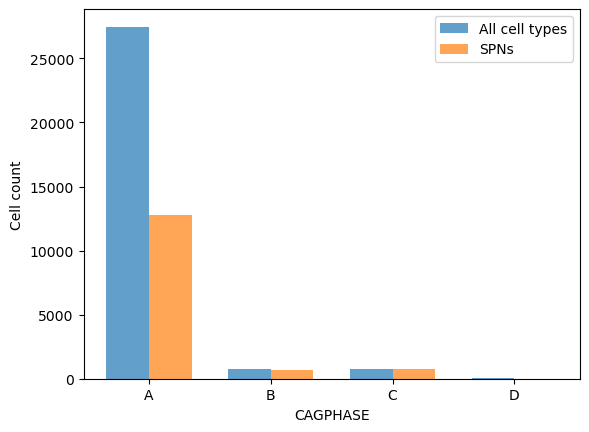

In [17]:
# Count CAGPHASE for all cells and SPNs
all_counts = all_adata.obs['CAGPHASE'].value_counts().sort_index()
spn_counts = all_adata.obs[all_adata.obs['CELLTYPE'] == 'SPN']['CAGPHASE'].value_counts().sort_index()

# Ensure all CAGPHASE categories are present in both
phases = sorted(set(all_counts.index).union(spn_counts.index))
all_counts = all_counts.reindex(phases, fill_value=0)
spn_counts = spn_counts.reindex(phases, fill_value=0)

x = np.arange(len(phases))
width = 0.35

plt.bar(x - width/2, all_counts, width, label='All cell types', alpha=0.7)
plt.bar(x + width/2, spn_counts, width, label='SPNs', alpha=0.7)
plt.xticks(x, phases)
plt.xlabel('CAGPHASE')
plt.ylabel('Cell count')
# plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
all_counts

CAGPHASE
A    27470
B      741
C      761
D       21
Name: count, dtype: int64

In [16]:
# Load saved dataset
adata = ad.read_h5ad(proj_dir + 'deep_dive_adata_v3.h5')

In [17]:
adata.obs

,BARCODE,AGE,CELL_BARCODE,BATCH,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE,CAGPHASE
CELL_BARCODE,,,,,,,,,,,,,,,
S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,ATTTCTGCAGCGACCT,67,S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,S05202rxn1,AGGTCGCTGCAGAAAT.TGGATTAATGTA,460.0,593.0,67.0,POLYA,3074853.0,3075086.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,GATGACTAGGCTAAAT,67,S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,S05202rxn1,ATTTAGCCTAGTCATC.CCACACAATTTG,426.0,1196.0,15.0,EXON2,3074853.0,3116219.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,CATCCGTAGTCTAGAA,67,S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,S05202rxn1,TTCTAGACTACGGATG.GACAGGCCAGGA,645.0,1387.0,63.0,INTRON1,3074853.0,3075899.0,S05202,CD,SPN,A
S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,ACCAACAGTGTACATC,67,S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,S05202rxn1,GATGTACACTGTTGGT.ATGCAGGAAATC,1351.0,2215.0,156.0,INTRON1,3074877.0,3076449.0,S05202,CD,SPN,C
S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,TTCTCTCGTTGCTCCT,67,S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,S05202rxn1,AGGAGCAACGAGAGAA.TGAGTCCAATTG,1017.0,691.0,15.0,EXON2,3074853.0,3075088.0,S05202,CD,SPN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S05368_Caudate_DeepDive_rxn3_CAATGACAGGTCATTC,CAATGACAGGTCATTC,44,S05368_Caudate_DeepDive_rxn3_CAATGACAGGTCATTC,S05368rxn3,GAATGACCTGTCATTG.GACTTGCAAGGA,511.0,507.0,39.0,POLYA,3074853.0,3075088.0,S05368,CD,astrocyte,A
S05368_Caudate_DeepDive_rxn3_GGTTCTCTCCCAGGAC,GGTTCTCTCCCAGGAC,44,S05368_Caudate_DeepDive_rxn3_GGTTCTCTCCCAGGAC,S05368rxn3,GTCCTGGGAGAGAACC.AGTGTATCTCGA,422.0,450.0,16.0,POLYA,3074853.0,3075088.0,S05368,CD,astrocyte,A
S05368_Caudate_DeepDive_rxn3_CTCGAGGCAGAACATA,CTCGAGGCAGAACATA,44,S05368_Caudate_DeepDive_rxn3_CTCGAGGCAGAACATA,S05368rxn3,TATGTTCTGCCTCGAG.AATAGAAAAGGA,152.0,448.0,16.0,POLYA,3074853.0,3075087.0,S05368,CD,astrocyte,A


In [18]:
# Extract raw count matrix (cells x genes)
X = adata.layers["raw"]

# Get CAPHASE grouping
caphase = adata.obs["CAGPHASE"]

# Prepare a DataFrame for variability stats
results = []

for group in caphase.unique():
    # Subset indices for this group
    idx = np.where(caphase == group)[0]
    
    # Subset matrix
    X_group = X[idx, :].toarray()
    
    # Total counts per cell (library size)
    totals = np.array(X_group.sum(axis=1)).ravel()

    # Variability stats across cells
    mean_total = totals.mean()
    var_total = totals.var()
    std_total = totals.std()
    cv_total = std_total / (mean_total + 1e-8)

    results.append({
        "CAPHASE": group,
        "n_cells": len(idx),
        "mean_total_counts": mean_total,
        "variance_total_counts": var_total,
        "std_total_counts": std_total,
        "cv_total_counts": cv_total,
    })

In [19]:
variability_df = pd.DataFrame(results)

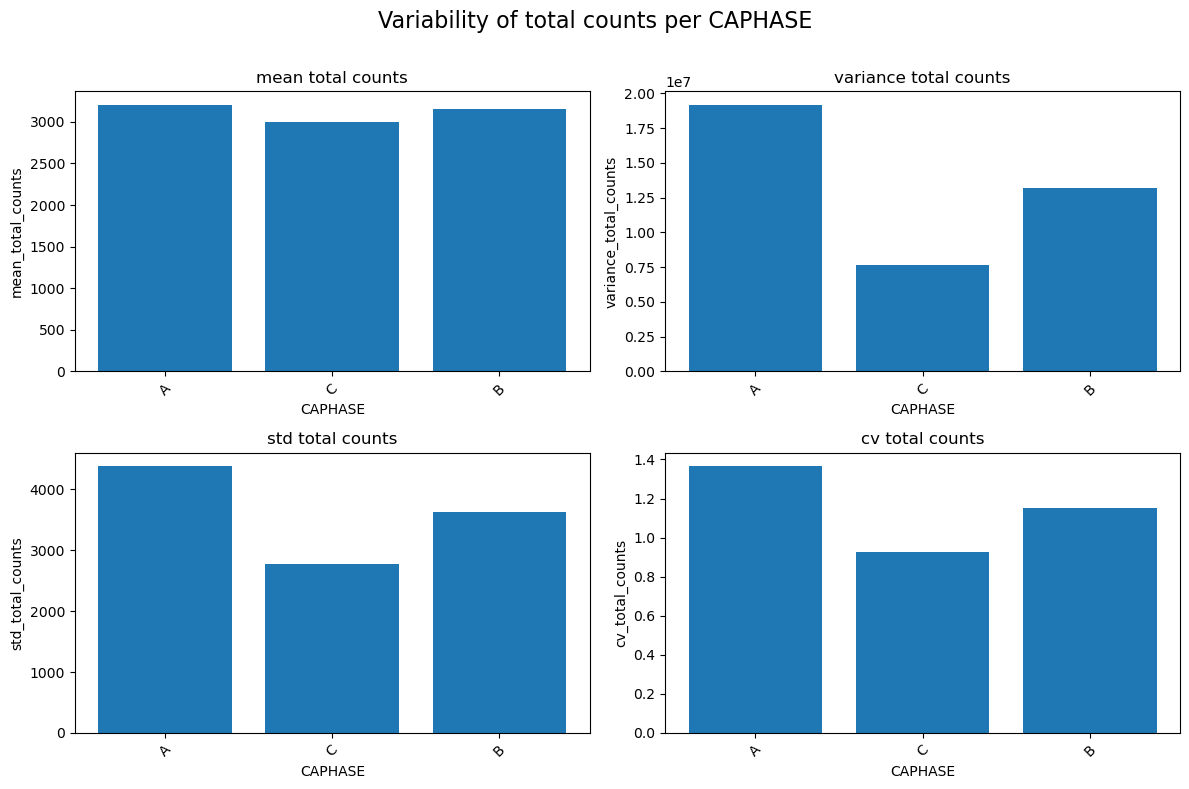

In [20]:

# Ensure CAPHASE is categorical for consistent plotting
variability_df["CAPHASE"] = variability_df["CAPHASE"].astype(str)

metrics = ["mean_total_counts", "variance_total_counts", "std_total_counts", "cv_total_counts"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid of subplots
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(variability_df["CAPHASE"], variability_df[metric])
    axes[i].set_title(metric.replace("_", " "))
    axes[i].set_xlabel("CAPHASE")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis="x", rotation=45)

fig.suptitle("Variability of total counts per CAPHASE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Dataset with PacBio and 10X data from sample S04002

In [17]:
all_adata.obs['TECHNOLOGY']='DeepDive'

In [ ]:
supervised_adata_multitech = all_adata.copy()
donor = 'S04002'
for file in os.listdir(snrna_counts_dir):
        if file.startswith(donor) & file.endswith('exonic+intronic.h5'):
            adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            print(adata.X.shape)
            adata.obs['TECHNOLOGY']='10X'
            supervised_adata_multitech = ad.concat([supervised_adata_multitech, adata], axis=0)

supervised_adata_multitech = supervised_adata_multitech[supervised_adata_multitech.obs['CAGPHASE'] != 'D']

In [26]:
supervised_adata_multitech.obs['DONOR'].value_counts()

S06758    6899
S12365    5121
S05202    4839
S04577    3894
S07681    2630
S02205    2374
S05368    1709
S09619    1506
S04002     271
Name: DONOR, dtype: int64

In [44]:
supervised_adata_multitech = norm_log(supervised_adata_multitech)
n_genes = 6000
supervised_adata_multitech = subset_hvgenes_v2(supervised_adata_multitech, n_genes, proj_dir)

/tmp/ipykernel_95735/290710596.py:5: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  all_adata.layers['raw'] = all_adata.X.copy()
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [45]:
supervised_adata_multitech.write_h5ad(proj_dir + f'multitech_supervised_adata_v2_{n_genes}.h5',compression='gzip')

In [41]:
proj_dir + f'multitech_supervised_adata_v2_{n_genes}.h5'

'/pool01/projects/abante_lab/cag_propagation/multitech_supervised_adata_v2_3000.h5'

# Dataset with PacBio and 10X data

In [11]:
def c_read_h5_10X(h5_file, meta_df, donor_meta):
    # Load the data from the HDF5 file
    with h5py.File(h5_file, "r") as f:

        # Assuming structure like: matrix/data, matrix/indices, etc.
        data = f['matrix/data'][:]
        indices = f['matrix/indices'][:]
        indptr = f['matrix/indptr'][:]
        shape = f['matrix/shape'][:]

        # Create a sparse matrix from the data
        # Note: The original matrix is in CSC format, we convert it to CSR format
        matrix = sp.csc_matrix((data, indices, indptr), shape=shape).transpose().tocsr()

        # Extract barcodes and gene names
        barcodes = f['matrix/barcodes'][:].astype(str)
        gene_names = f['matrix/features/name'][:].astype(str)
        feature_type = f['matrix/features/feature_type'][:].astype(str) # All are gene expression

    # Construct AnnData object manually
    adata = ad.AnnData(X=matrix)
    adata.obs['BARCODE'] = barcodes
    adata.var_names = gene_names

    # Construct cell barcode
    vilrun = h5_file.split('/')[-1].split('.')[0].split('_')[1:3]
    adata.obs['CELL_BARCODE'] = '_'.join(vilrun) + '_' + adata.obs['BARCODE']

    # Filter metadata for this sample
    sample_10X = meta_df[meta_df['CELL_BARCODE'].isin(adata.obs['CELL_BARCODE'])]

    # join metadata to AnnData object observation
    adata.obs = adata.obs.set_index('CELL_BARCODE', drop=False)
    adata.obs = adata.obs.join(sample_10X.set_index('CELL_BARCODE'), how='left', lsuffix='_snrnadata')

    # Create mapping from donor ID to Age
    donor_age_map = donor_meta.set_index('SID')['Age'].to_dict()

    # Map age to each donor in adata.obs['DONOR']
    adata.obs['AGE'] = adata.obs['DONOR'].map(donor_age_map)

    return adata

In [ ]:
donors = ['S05202', 'S12365', 'S04577', 'S07681', 'S06758', 'S09619', 'S02205', 'S05368']

# First donor anndata
all_adata = None

for file in os.listdir(snrna_counts_dir):
    # pacbio files
    if (file.split('/')[-1].split('_')[0] in donors) & (file.endswith('exonic+intronic.h5')):
        if not all_adata:
            all_adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            all_adata.obs['TECHNOLOGY']='PACBIO'

        else:
            adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            adata.obs['TECHNOLOGY']='PACBIO'
            all_adata = ad.concat([all_adata, adata], axis=0, join="outer")

    elif file.startswith('S04002') & file.endswith('exonic+intronic.h5'):
        if not all_adata:
            all_adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            all_adata.obs['TECHNOLOGY']='10X'
        else:
            adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            print(adata.X.shape)
            adata.obs['TECHNOLOGY']='10X'
            all_adata = ad.concat([all_adata, adata], axis=0)

    # 10x files
    elif file.startswith('CHDI') and file.endswith('exonic+intronic.donors.h5'):
        if not all_adata:
                all_adata = c_read_h5_10X(snrna_counts_dir + file, village_metadata, donor_metadata)
                all_adata.obs['TECHNOLOGY']='10X'
        else:
            adata = c_read_h5_10X(snrna_counts_dir + file, village_metadata, donor_metadata)
            adata.obs['TECHNOLOGY']='10X'
            all_adata = ad.concat([all_adata, adata], axis=0, join="outer")


/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)


(0, 35122)


/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)


(0, 34724)


/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)


(0, 35378)


/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAGPHASE'] = adata.obs['CAGLENGTH'].apply(assign_cag_phase)
/tmp/ipykernel_54007/1075236743.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.

In [18]:
all_adata = ad.read_h5ad(proj_dir + f'deep_dive_10x_adata.h5')

In [19]:
all_adata.obs['TECHNOLOGY'].value_counts()

TECHNOLOGY
10X       680587
PACBIO     28993
Name: count, dtype: int64

In [ ]:
# Add samples from S04002
donor = 'S04002'
for file in os.listdir(snrna_counts_dir):
        if file.startswith(donor) & file.endswith('exonic+intronic.h5'):
            adata = c_read_h5_pacbio(snrna_counts_dir + file, pacbio, donor_metadata)
            print(adata.X.shape)
            adata.obs['TECHNOLOGY']='10X'
            all_adata = ad.concat([all_adata, adata], axis=0)

all_adata = all_adata[all_adata.obs['CAGPHASE'] != 'D']

In [21]:
all_adata.obs['TECHNOLOGY'].value_counts()

TECHNOLOGY
10X       680858
PACBIO     28972
Name: count, dtype: int64

In [22]:
all_adata.write_h5ad(proj_dir + f'deep_dive_10x_adata.h5',compression='gzip')

/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as ac

In [29]:
all_adata = norm_log(all_adata)
all_adata.layers

Layers with keys: raw, counts

In [ ]:
# Filter data to 2k most variable genes
n_genes = 6000
all_adata = subset_hvgenes_v1(all_adata, n_genes, proj_dir)

In [38]:
# Change PACBIO technology name to DeepDive
all_adata.obs['TECHNOLOGY'] = all_adata.obs['TECHNOLOGY'].replace({'PACBIO': 'DeepDive'})

/tmp/ipykernel_56081/714768904.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_adata.obs['TECHNOLOGY'] = all_adata.obs['TECHNOLOGY'].replace({'PACBIO': 'DeepDive'})


In [39]:
all_adata.obs['TECHNOLOGY'].value_counts()

TECHNOLOGY
10X         680858
DeepDive     28972
Name: count, dtype: int64

In [40]:
# Save anndata object
all_adata.write_h5ad(proj_dir + f'deep_dive_10x_adata_v1_{n_genes}.h5',compression='gzip')

In [ ]:
# Boolean mask for PACBIO and 10X cells
is_pacbio = all_adata.obs['TECHNOLOGY'] == 'PACBIO'
is_10x = all_adata.obs['TECHNOLOGY'] == '10X'

# Select all PACBIO
pacbio_subset = all_adata[is_pacbio]

# Random 10% sample of 10X
sample_10x_subset = all_adata[is_10x].obs.sample(frac=0.1, random_state=42).index
tenx_subset = all_adata[sample_10x_subset]

# Concatenate both
subset_adata = ad.concat([pacbio_subset, tenx_subset], axis=0)

In [ ]:
# Save anndata object
subset_adata.write_h5ad(proj_dir + 'deep_dive_10x_test0.1_adata.h5',compression='gzip')

In [ ]:
# Random s ample of 10X to make it 50/50 with DeepDive
sample_10x_subset = all_adata[is_10x].obs.sample(n=sum(all_adata.obs['TECHNOLOGY'] == 'DeepDive'), random_state=42).index
tenx_subset = all_adata[sample_10x_subset]

# Concatenate both
subset_adata = ad.concat([pacbio_subset, tenx_subset], axis=0)

In [45]:
subset_adata.obs['TECHNOLOGY'].value_counts()

TECHNOLOGY
10X         28972
DeepDive    28972
Name: count, dtype: int64

In [ ]:
# Save anndata object
subset_adata.write_h5ad(proj_dir + 'deep_dive_10x_v1_6k_test0.5_adata.h5',compression='gzip')

## Multitech with other datasets

In [ ]:
# deepdive handsaker:
# handsaker_deepdive_adata = ad.read_h5ad(proj_dir + "handsaker_pacbio_deepdive.h5")
handsaker_deepdive_adata = supervised_adata_multitech.copy()

### Thompson

In [47]:
# thompson rnaseq:
ctrl_thompson = sc.read_10x_h5('data/public/thompson_lab/cellranger/18n6_Aug29/outs/filtered_gene_bc_matrices_h5.h5')
hd_thompson = sc.read_10x_h5("data/public/thompson_lab/cellranger/53n3_Aug29/outs/filtered_gene_bc_matrices_h5.h5")

/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [48]:
ctrl_thompson

AnnData object with n_obs × n_vars = 5070 × 32738
    var: 'gene_ids'

In [49]:
dupes = ctrl_thompson.var_names[ctrl_thompson.var_names.duplicated()]
ctrl_thompson.var.loc[dupes, :]

,gene_ids
U1,ENSG00000233421
U1,ENSG00000228549
EFNA3,ENSG00000143590
EFNA3,ENSG00000251246
DCAF8,ENSG00000132716
...,...
KIR3DL2,ENSG00000217792
PNRC2,ENSG00000189266
PNRC2,ENSG00000215700
SRSF10,ENSG00000188529


There are duplicate var_names because some ENSEMBL IDs map to the same gene symbol. We sum the counts of the columns pertaining to the same gene name:

In [50]:
def collapse_duplicate_genes(adata):    
    # Convert to dense or sparse DataFrame
    X = adata.X.toarray() if sp.issparse(adata.X) else adata.X
    df = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)

    # Collapse by summing over duplicate gene names
    df_sum = df.groupby(df.columns, axis=1).sum()

    # Create a new AnnData object with the collapsed matrix
    adata_collapsed = sc.AnnData(
        X=sp.csr_matrix(df_sum.values),
        obs=adata.obs.copy(),
        var=pd.DataFrame(index=df_sum.columns)
    )
    return adata_collapsed

ctrl_thompson = collapse_duplicate_genes(ctrl_thompson)
hd_thompson = collapse_duplicate_genes(hd_thompson)

In [51]:
ctrl_thompson.var_names.duplicated().sum(), hd_thompson.var_names.duplicated().sum()

(0, 0)

In [52]:
# Subset to common genes
common_genes = (
    ctrl_thompson.var_names
    .intersection(hd_thompson.var_names)
    .intersection(handsaker_deepdive_adata.var_names)
)
ctrl_thompson = ctrl_thompson[:, common_genes].copy()
hd_thompson = hd_thompson[:, common_genes].copy()
handsaker_deepdive_adata = handsaker_deepdive_adata[:, common_genes].copy()

In [54]:
# Create counts layer to preserve raw counts intact
handsaker_deepdive_adata.layers['raw'] = handsaker_deepdive_adata.X.copy()
handsaker_deepdive_adata.layers['counts'] = handsaker_deepdive_adata.X.copy()

# Normalize and log transform
sc.pp.normalize_total(handsaker_deepdive_adata, target_sum=1e4, layer='counts')
sc.pp.log1p(handsaker_deepdive_adata, layer='counts')

In [55]:
# Use v2 6k gene subset
n_genes = 3000
sc.pp.highly_variable_genes(
    handsaker_deepdive_adata,
    layer='counts',
    flavor='seurat_v3',   # allows batch-aware HVG selection
    batch_key='CAGPHASE',  # use CAPHASE as batches
    n_top_genes=n_genes,
    subset=True
)

del handsaker_deepdive_adata.layers['counts']

/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [57]:
# Filter to genes in handsaker_deepdive_adata
gene_list = handsaker_deepdive_adata.var_names
ctrl_thompson = ctrl_thompson[:, gene_list]
hd_thompson = hd_thompson[:, gene_list]

In [58]:
handsaker_deepdive_adata.obs

,BARCODE,AGE,CELL_BARCODE,BATCH,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE,CAGPHASE,TECHNOLOGY
CELL_BARCODE,,,,,,,,,,,,,,,,
S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,ATTTCTGCAGCGACCT,67,S05202_Caudate_DeepDive_rxn1_ATTTCTGCAGCGACCT,S05202rxn1,AGGTCGCTGCAGAAAT.TGGATTAATGTA,460.0,593.0,67.0,POLYA,3074853.0,3075086.0,S05202,CD,SPN,A,DeepDive
S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,GATGACTAGGCTAAAT,67,S05202_Caudate_DeepDive_rxn1_GATGACTAGGCTAAAT,S05202rxn1,ATTTAGCCTAGTCATC.CCACACAATTTG,426.0,1196.0,15.0,EXON2,3074853.0,3116219.0,S05202,CD,SPN,A,DeepDive
S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,CATCCGTAGTCTAGAA,67,S05202_Caudate_DeepDive_rxn1_CATCCGTAGTCTAGAA,S05202rxn1,TTCTAGACTACGGATG.GACAGGCCAGGA,645.0,1387.0,63.0,INTRON1,3074853.0,3075899.0,S05202,CD,SPN,A,DeepDive
S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,ACCAACAGTGTACATC,67,S05202_Caudate_DeepDive_rxn1_ACCAACAGTGTACATC,S05202rxn1,GATGTACACTGTTGGT.ATGCAGGAAATC,1351.0,2215.0,156.0,INTRON1,3074877.0,3076449.0,S05202,CD,SPN,C,DeepDive
S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,TTCTCTCGTTGCTCCT,67,S05202_Caudate_DeepDive_rxn1_TTCTCTCGTTGCTCCT,S05202rxn1,AGGAGCAACGAGAGAA.TGAGTCCAATTG,1017.0,691.0,15.0,EXON2,3074853.0,3075088.0,S05202,CD,SPN,A,DeepDive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S04002_rxn1_GAGACTTTCCATCTCG,GAGACTTTCCATCTCG,58,S04002_rxn1_GAGACTTTCCATCTCG,S04002rxn1,CGAGATGGAAAGTCTC.ATAAATAGTGCG,293.0,443.0,17.0,POLYA,3074853.0,3075088.0,S04002,CD,astrocyte,A,10X
S04002_rxn1_CATTGCCGTACGAAAT,CATTGCCGTACGAAAT,58,S04002_rxn1_CATTGCCGTACGAAAT,S04002rxn1,ATTTCGTACGGCAATG.GAACCGTCGATA,104.0,769.0,41.0,EXON2,3074853.0,3103882.0,S04002,CD,astrocyte,A,10X
S04002_rxn1_AGATGCTCAGTTAGGG,AGATGCTCAGTTAGGG,58,S04002_rxn1_AGATGCTCAGTTAGGG,S04002rxn1,CCCTAACTGAGCATCT.TAGATTTCGACA,331.0,518.0,43.0,POLYA,3074853.0,3075086.0,S04002,CD,polydendrocyte,A,10X


In [59]:
hd_thompson.obs['TECHNOLOGY'] = '10X'
ctrl_thompson.obs['TECHNOLOGY'] = '10X'
# handsaker_deepdive_adata.obs['TECHNOLOGY'] = 'DeepDive'

/tmp/ipykernel_95735/3459162791.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hd_thompson.obs['TECHNOLOGY'] = '10X'
/tmp/ipykernel_95735/3459162791.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl_thompson.obs['TECHNOLOGY'] = '10X'


In [60]:
hd_thompson.obs['ORIGIN'] = 'HD_Thompson2020'
ctrl_thompson.obs['ORIGIN'] = 'CTRL_Thompson2020'
handsaker_deepdive_adata.obs['ORIGIN'] = 'Handsaker2024'

hd_thompson.obs['CAGPHASE'] = None
ctrl_thompson.obs['CAGPHASE'] = None

hd_thompson.obs['DONOR'] = 'Cs03iHD53n3'
ctrl_thompson.obs['DONOR'] = 'CS25iCTR18n6'

hd_thompson.obs['CELLTYPE'] = None
ctrl_thompson.obs['CELLTYPE'] = None

In [61]:
# Merge the three datasets
all_adata = ad.concat([handsaker_deepdive_adata, hd_thompson, ctrl_thompson], axis=0, join="outer")

/pool01/conda/envs/cag_snRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [62]:
# Save the combined AnnData object
# all_adata.write_h5ad(proj_dir + 'handsaker_deepdive_thompson2020.h5', compression='gzip')
all_adata.write_h5ad(proj_dir + 'handsaker_deepdive10X_thompson2020.h5', compression='gzip')